In [29]:
import geopandas as gpd # Geospatial data operations
import pandas as pd # Tabular data operations
from glob import glob # Finding files
import os
import matplotlib # Plotting
import contextily as cx # Basemaps
cx.set_cache_dir("tile_cache")
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, Polygon
matplotlib.rcParams['figure.figsize'] = (20, 10)
files = glob("Onehunga_POI0322/*.shp")
files

['Onehunga_POI0322/onehunga_park.shp',
 'Onehunga_POI0322/onehunga_medical_point.shp',
 'Onehunga_POI0322/onehunga_supm_conve.shp',
 'Onehunga_POI0322/onehunga_rest_cafe.shp',
 'Onehunga_POI0322/onehunga_busstop_point.shp',
 'Onehunga_POI0322/onehunga_school.shp']

In [52]:
dfs = []
for f in files:
    # Read in each shapefile
    df = gpd.read_file(f)
    # Record the category based on the filename
    df["category"] = os.path.splitext(os.path.basename(f))[0].replace("onehunga_", "")
    dfs.append(df)

# Reproject to NZGD2000 (EPSG:2193), so units are in meters, not degrees
df = pd.concat(dfs).to_crs(2193)
# Drop bad rows (no geometry)
df.dropna(subset="geometry", inplace=True)
df.reset_index(inplace=True, drop=True)
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


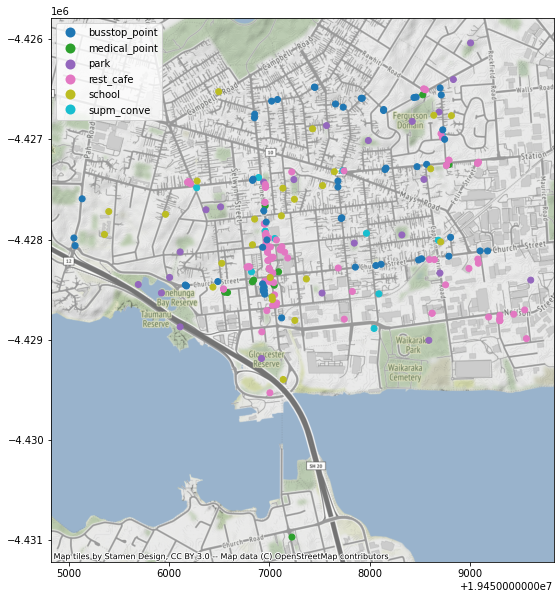

In [43]:
ax = df.to_crs(epsg=3857).plot(column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [53]:
# Distance calculation
for c in df.category.unique():
    # sindex.nearest will return the closest point within this category for each element in df.geometry
    points_in_category = df[df.category == c]
    indices, distances = points_in_category.sindex.nearest(df.geometry, return_distance=True)
    df[f"nearest_{c}"] = points_in_category.index[indices[1]]
    df[f"nearest_{c}_distance_m"] = distances
df[df.columns[df.columns.str.startswith("nearest")]]

,nearest_park,nearest_park_distance_m,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m
0,0,0.000000,36,590.025525,44,496.858283,88,211.290628,197,360.558330,218,240.441996
1,1,0.000000,31,860.403844,41,261.268927,126,104.075998,153,151.234066,220,247.500057
2,2,0.000000,27,188.876672,48,180.339191,132,173.100288,167,137.103061,204,48.805781
3,3,0.000000,32,386.003804,44,400.332350,91,237.351935,147,336.527784,208,168.054720
4,4,0.000000,32,645.892148,46,124.991587,91,235.795972,147,190.992889,208,476.945562
...,...,...,...,...,...,...,...,...,...,...,...,...
219,8,320.710845,24,778.714386,47,326.137857,56,309.515961,182,583.467296,219,0.000000
220,1,247.500057,31,613.196811,41,23.383489,127,149.331308,198,87.040715,220,0.000000
221,5,804.469904,28,979.367432,45,752.951594,57,753.090981,179,338.401875,221,0.000000
222,15,625.817057,24,1125.738461,47,726.775427,56,670.716967,195,235.472247,222,0.000000


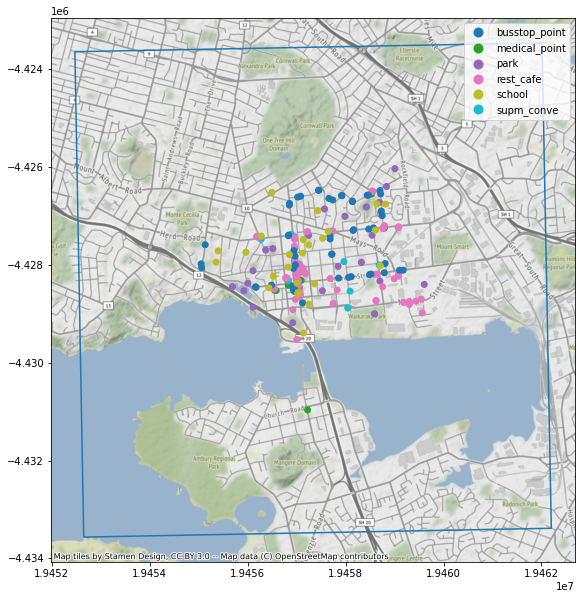

In [9]:
# Calculate Area of Interest (AOI). This is the bounds of the dataset, plus a 2KM buffer
AOI = df.dissolve().buffer(2000).envelope
ax = AOI.to_crs(epsg=3857).boundary.plot()
df.to_crs(epsg=3857).plot(ax=ax, column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [18]:
# Adapted from https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [19]:
# download the street network
G = ox.graph_from_polygon(AOI.to_crs(4326)[0], network_type=network_type)

In [34]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G, 2193)

In [35]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [36]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

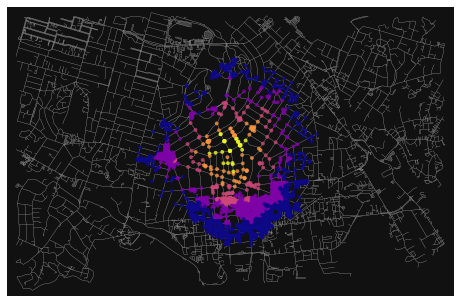

In [37]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [38]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

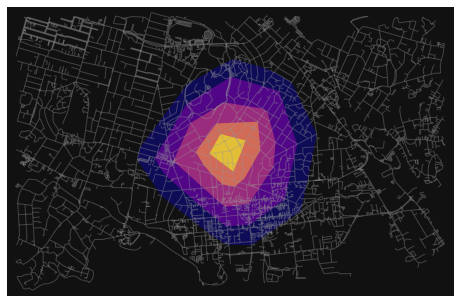

In [39]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

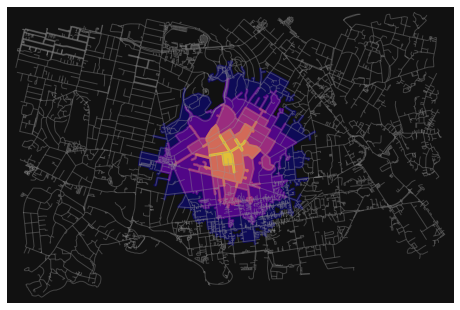

In [33]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

In [5]:
sample = df.sample(1)
sample

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m
68,112.0,-36.925619,174.807092,ONEHUNGA CLASSIC BAKERY & CAFE,ChIJFfZL3NJIDW0Rb6lSQgBzvjU,POINT (1760951.905 5911853.701),rest_cafe,113.0,NaN,NaN,...,3,1296.645934,4,841.810599,68,0.0,9,544.1354,21,818.728243
